# **Data Cleaning**

In [1]:
#imports
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from surprise import SVD, Dataset, Reader
from sklearn.metrics.pairwise import cosine_similarity

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:

# Specify the file path
file_path = 'C:/Users/brand/Downloads/MSAAI-540-Final/Dataset/DatafinitiElectronicsProductData.csv'

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)
data.head()


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,...,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
2,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,I love the new design the keys are spaced well...,New,Kman,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
3,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,Attached easily and firmly. Has a nice feel. A...,Nice keyboard,UpstateNY,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
4,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"Our original keyboard was okay, but did not ha...",Nice improvement,Glickster,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds


Handling Missing Values

In [4]:
# Check for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

colors                 2019
dimension              1209
ean                    4348
manufacturer           2667
reviews.date             61
reviews.doRecommend    1391
reviews.numHelpful     1486
reviews.rating          164
reviews.text              5
reviews.title             4
dtype: int64



*   colors, dimension, ean, manufacturer:
    - These columns are not critical for our recommendation system. We'll drop these columns if necessary.

*   reviews.doRecommend, reviews.numHelpful, reviews.rating:
    - Impute or drop based on the analysis. For reviews.rating, it is critical, so we may drop rows with missing values.



In [5]:
# Drop columns with a high number of missing values
data_cleaned = data.drop(columns=['colors', 'dimension', 'ean', 'manufacturer'])

# Drop rows with missing review text or title
data_cleaned = data_cleaned.dropna(subset=['reviews.text', 'reviews.title'])

# Impute missing 'reviews.date' with a placeholder
data_cleaned['reviews.date'].fillna('Unknown', inplace=True)

# Drop rows with missing 'reviews.rating'
data_cleaned = data_cleaned.dropna(subset=['reviews.rating'])

# For 'reviews.doRecommend' and 'reviews.numHelpful', we'll impute missing values with the median
data_cleaned['reviews.doRecommend'].fillna(data_cleaned['reviews.doRecommend'].mode()[0], inplace=True)
data_cleaned['reviews.numHelpful'].fillna(data_cleaned['reviews.numHelpful'].median(), inplace=True)

# Display the cleaned data
data_cleaned.head()

,id,asins,brand,categories,dateAdded,dateUpdated,imageURLs,keys,manufacturerNumber,name,...,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
2,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,I love the new design the keys are spaced well...,New,Kman,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
3,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,Attached easily and firmly. Has a nice feel. A...,Nice keyboard,UpstateNY,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
4,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"Our original keyboard was okay, but did not ha...",Nice improvement,Glickster,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds


Data Type Coversion

In [6]:
# Convert 'dateAdded' and 'dateUpdated' to datetime
data_cleaned['dateAdded'] = pd.to_datetime(data_cleaned['dateAdded'], errors='coerce')
data_cleaned['dateUpdated'] = pd.to_datetime(data_cleaned['dateUpdated'], errors='coerce')

# Convert 'reviews.rating' to numeric
data_cleaned['reviews.rating'] = pd.to_numeric(data_cleaned['reviews.rating'], errors='coerce')

# Display the data types to confirm changes
data_cleaned.dtypes

id                                  object
asins                               object
brand                               object
categories                          object
dateAdded              datetime64[ns, UTC]
dateUpdated            datetime64[ns, UTC]
imageURLs                           object
keys                                object
manufacturerNumber                  object
name                                object
primaryCategories                   object
reviews.date                        object
reviews.dateSeen                    object
reviews.doRecommend                   bool
reviews.numHelpful                 float64
reviews.rating                     float64
reviews.sourceURLs                  object
reviews.text                        object
reviews.title                       object
reviews.username                    object
sourceURLs                          object
upc                                float64
weight                              object
dtype: obje

Duplicate Removal

In [7]:
# Check for duplicates
duplicates = data_cleaned.duplicated().sum()

# Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()

# Display the number of duplicates found and removed
duplicates

0

Standardize Text Data

In [8]:
# Standardize text data: Convert to lowercase and strip extra spaces
data_cleaned['reviews.text'] = data_cleaned['reviews.text'].str.lower().str.strip()
data_cleaned['reviews.title'] = data_cleaned['reviews.title'].str.lower().str.strip()
data_cleaned['brand'] = data_cleaned['brand'].str.lower().str.strip()
data_cleaned['categories'] = data_cleaned['categories'].str.lower().str.strip()

# Display the cleaned text data
data_cleaned[['reviews.text', 'reviews.title', 'brand', 'categories']].head()

,reviews.text,reviews.title,brand,categories
0,"this keyboard is very easy to type on, but the...",love the fingerprint reader,microsoft,"electronics,computers,computer accessories,key..."
1,it's thin and light. i can type pretty easily ...,nice,microsoft,"electronics,computers,computer accessories,key..."
2,i love the new design the keys are spaced well...,new,microsoft,"electronics,computers,computer accessories,key..."
3,attached easily and firmly. has a nice feel. a...,nice keyboard,microsoft,"electronics,computers,computer accessories,key..."
4,"our original keyboard was okay, but did not ha...",nice improvement,microsoft,"electronics,computers,computer accessories,key..."


Outlier Detection and Handling

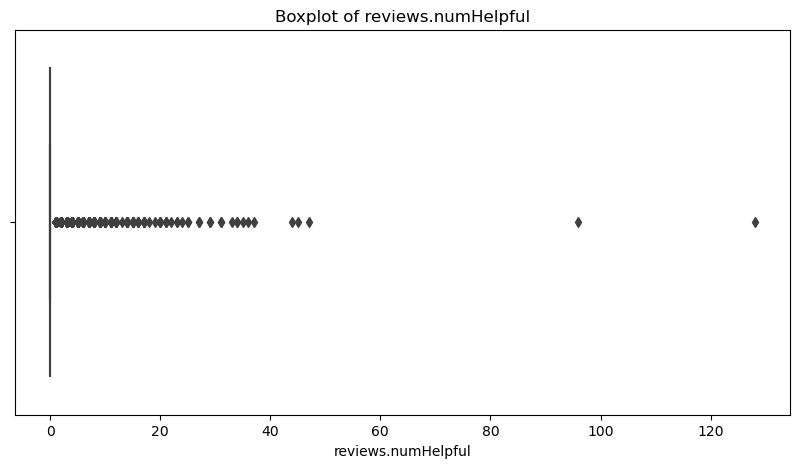

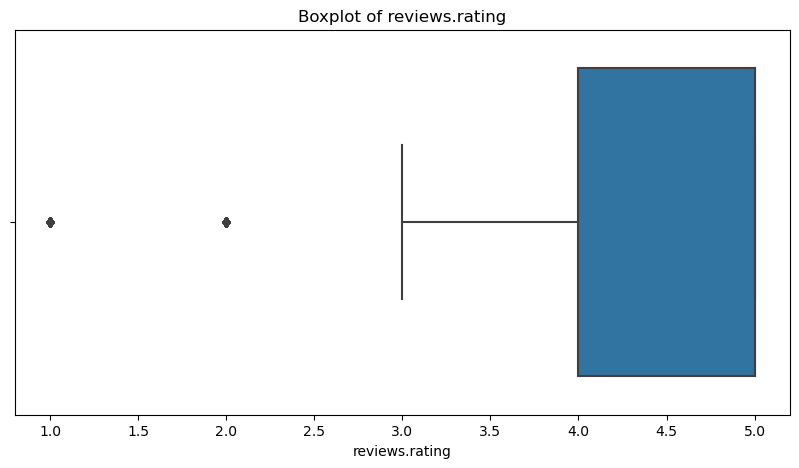

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot boxplots for numerical columns
def plot_boxplots(df, cols):
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Plot boxplots for 'reviews.numHelpful' and 'reviews.rating'
plot_boxplots(data_cleaned, ['reviews.numHelpful', 'reviews.rating'])

From the boxplots, we can observe the presence of outliers in the reviews.numHelpful column. The reviews.rating column appears to be within a normal range, considering it's a typical 5-point rating scale.

Handling Outliers

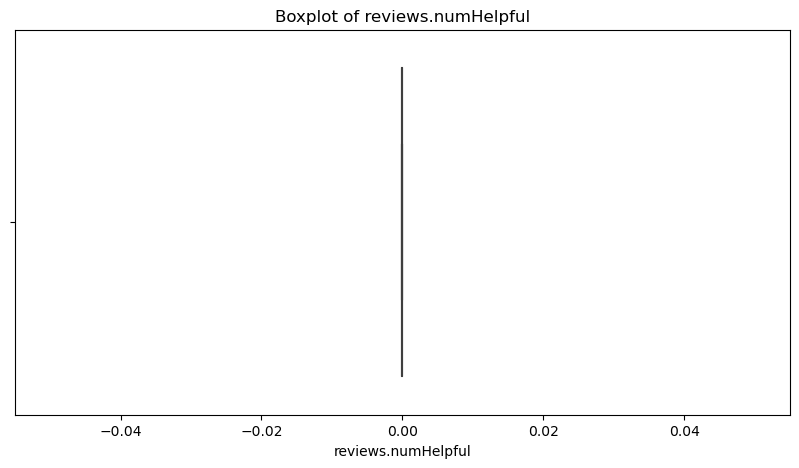

In [10]:
# Function to cap outliers
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Cap outliers in 'reviews.numHelpful'
cap_outliers(data_cleaned, 'reviews.numHelpful')

# Plot the boxplot again to verify
plot_boxplots(data_cleaned, ['reviews.numHelpful'])

In the context of reviews.numHelpful, an outlier might be a review marked as exceptionally helpful or unhelpful by an unusually high number of users compared to others.
These extreme values can skew statistical analyses and may disproportionately influence model training, leading to biased or unstable models.
By capping values outside 1.5 times the IQR above the third quartile (Q3) and below the first quartile (Q1), we effectively limit the influence of extreme outliers.


# **Feature Engineering**

Create New Features:
* Review Length: The length of the review text.

* Average Rating Per Product: The average rating for each product.


In [11]:
# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
    # Tokenize and remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin tokens into a single string
    return ' '.join(tokens)

# Apply the preprocessing function to the reviews
data_cleaned['processed_reviews'] = data_cleaned['reviews.text'].apply(preprocess_text)

# Display the processed reviews
data_cleaned[['reviews.text', 'processed_reviews']].head()

,reviews.text,processed_reviews
0,"this keyboard is very easy to type on, but the...",keyboard easy type fingerprint reader best fea...
1,it's thin and light. i can type pretty easily ...,thin light type pretty easily
2,i love the new design the keys are spaced well...,love new design key spaced well mi type finger...
3,attached easily and firmly. has a nice feel. a...,attached easily firmly nice feel must surface pro
4,"our original keyboard was okay, but did not ha...",original keyboard okay laptop feel bit floppy ...


Simplified Text Preprocessing


In [12]:
import re

# Predefined list of stop words (a small subset)
simple_stop_words = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
                         "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them",
                         "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am",
                         "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did",
                         "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at",
                         "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after",
                         "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
                         "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
                         "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same",
                         "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

# Function for simplified text preprocessing
def simple_preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stop words
    tokens = text.split()
    tokens = [word for word in tokens if word not in simple_stop_words]

    return ' '.join(tokens)

# Apply the simplified preprocessing function to the reviews
data_cleaned['processed_reviews'] = data_cleaned['reviews.text'].apply(simple_preprocess_text)

# Display the processed reviews
data_cleaned[['reviews.text', 'processed_reviews']].head()

,reviews.text,processed_reviews
0,"this keyboard is very easy to type on, but the...",keyboard easy type fingerprint reader best fea...
1,it's thin and light. i can type pretty easily ...,thin light type pretty easily
2,i love the new design the keys are spaced well...,love new design keys spaced well mis types fin...
3,attached easily and firmly. has a nice feel. a...,attached easily firmly nice feel must surface pro
4,"our original keyboard was okay, but did not ha...",original keyboard okay laptop feel bit floppy ...


Review Sentiment Analysis

In [13]:
# Define a function to categorize sentiment based on rating
def sentiment_from_rating(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to create a new 'sentiment' column
data_cleaned['sentiment'] = data_cleaned['reviews.rating'].apply(sentiment_from_rating)

# Display the new 'sentiment' column
data_cleaned[['reviews.rating', 'sentiment']].head()

,reviews.rating,sentiment
0,5.0,positive
1,4.0,positive
2,4.0,positive
3,5.0,positive
4,5.0,positive




1. Ratings 4 and 5 are considered positive.
2. Rating 3 is considered neutral.
3. Ratings 1 and 2 are considered negative.


In [14]:
 #Define a function to categorize sentiment based on rating
def sentiment_from_rating(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to create a new 'sentiment' column
data_cleaned['sentiment'] = data_cleaned['reviews.rating'].apply(sentiment_from_rating)

# Display the new 'sentiment' column along with processed reviews
data_cleaned[['processed_reviews', 'sentiment']].head()

,processed_reviews,sentiment
0,keyboard easy type fingerprint reader best fea...,positive
1,thin light type pretty easily,positive
2,love new design keys spaced well mis types fin...,positive
3,attached easily firmly nice feel must surface pro,positive
4,original keyboard okay laptop feel bit floppy ...,positive


 Create a feature for the word count of each review.

In [15]:
# Create a new feature 'word_count'
data_cleaned['word_count'] = data_cleaned['reviews.text'].apply(lambda x: len(x.split()))

# Display the new 'word_count' column
data_cleaned[['reviews.text', 'word_count']].head()

,reviews.text,word_count
0,"this keyboard is very easy to type on, but the...",23
1,it's thin and light. i can type pretty easily ...,11
2,i love the new design the keys are spaced well...,29
3,attached easily and firmly. has a nice feel. a...,14
4,"our original keyboard was okay, but did not ha...",32


 Number of Reviews Per Product

In [16]:
data_cleaned.columns

Index(['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'imageURLs', 'keys', 'manufacturerNumber', 'name', 'primaryCategories',
       'reviews.date', 'reviews.dateSeen', 'reviews.doRecommend',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'upc', 'weight', 'processed_reviews', 'sentiment', 'word_count'],
      dtype='object')

In [17]:
# Create a 'num_reviews' column by counting the number of reviews for each product
data_cleaned['num_reviews'] = data_cleaned.groupby('name')['reviews.text'].transform('count')

In [18]:
# Check for existing 'num_reviews' column and handle it
if 'num_reviews' in data_cleaned.columns:
    data_cleaned = data_cleaned.drop(columns=['num_reviews'])

# Calculate the number of reviews per product based on the product name
num_reviews_per_product = data_cleaned['name'].value_counts().reset_index()
num_reviews_per_product.columns = ['name', 'num_reviews']

# Merge the number of reviews with the main dataset
data_cleaned = data_cleaned.merge(num_reviews_per_product, on='name', how='left')

# Display the new 'num_reviews' column
print(data_cleaned[['name', 'num_reviews']].head())

                                                name  num_reviews
0  Microsoft Surface Pro 4 Type Cover with Finger...          495
1  Microsoft Surface Pro 4 Type Cover with Finger...          495
2  Microsoft Surface Pro 4 Type Cover with Finger...          495
3  Microsoft Surface Pro 4 Type Cover with Finger...          495
4  Microsoft Surface Pro 4 Type Cover with Finger...          495


In [19]:
data_cleaned.to_csv('cleaned_data_with_features.csv', index=False)

In [20]:
# Load the CSV file
cleaned_data_path = 'C:/Users/brand/Downloads/MSAAI-540-Final/Dataset/cleaned_data_with_features.csv'
data_cleaned = pd.read_csv(cleaned_data_path)

# Handle missing values in 'reviews.text'
data_cleaned['reviews.text'] = data_cleaned['reviews.text'].fillna('')

# Adding additional features
data_cleaned['review_length'] = data_cleaned['reviews.text'].apply(len)
data_cleaned['word_count'] = data_cleaned['reviews.text'].apply(lambda x: len(x.split()))
data_cleaned['sentiment'] = data_cleaned['reviews.rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

# Display the new columns
print(data_cleaned[['reviews.text', 'review_length', 'word_count', 'sentiment']].head())

                                        reviews.text  review_length  \
0  this keyboard is very easy to type on, but the...            128   
1  it's thin and light. i can type pretty easily ...             52   
2  i love the new design the keys are spaced well...            135   
3  attached easily and firmly. has a nice feel. a...             73   
4  our original keyboard was okay, but did not ha...            153   

   word_count sentiment  
0          23  positive  
1          11  positive  
2          29  positive  
3          14  positive  
4          32  positive  


In [21]:
data_cleaned.columns

Index(['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'imageURLs', 'keys', 'manufacturerNumber', 'name', 'primaryCategories',
       'reviews.date', 'reviews.dateSeen', 'reviews.doRecommend',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'upc', 'weight', 'review_length', 'average_rating_x', 'sentiment',
       'word_count', 'num_reviews', 'num_reviews.1', 'processed_reviews',
       'average_rating_y', 'average_rating'],
      dtype='object')

In [22]:
# Rename the correct 'num_reviews' column and drop the other one
#data_cleaned = data_cleaned.drop(columns=['num_reviews_x'])
data_cleaned = data_cleaned.rename(columns={'num_reviews_y': 'num_reviews'})

# Display the cleaned dataframe with the correct 'num_reviews' column
data_cleaned[['name', 'num_reviews']].head()

,name,num_reviews
0,Microsoft Surface Pro 4 Type Cover with Finger...,495
1,Microsoft Surface Pro 4 Type Cover with Finger...,495
2,Microsoft Surface Pro 4 Type Cover with Finger...,495
3,Microsoft Surface Pro 4 Type Cover with Finger...,495
4,Microsoft Surface Pro 4 Type Cover with Finger...,495


# **Exploratory Data Analysis**

Distribution of Ratings

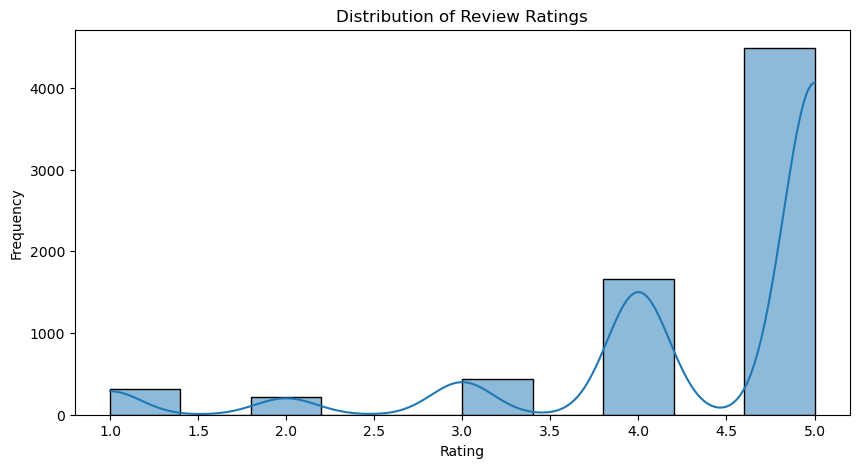

In [23]:
# Plot the distribution of review ratings
plt.figure(figsize=(10, 5))
sns.histplot(data_cleaned['reviews.rating'], bins=10, kde=True)
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

The histogram shows that most reviews have high ratings, with a significant number of 4 and 5-star reviews. This is typical for product reviews on e-commerce platforms.

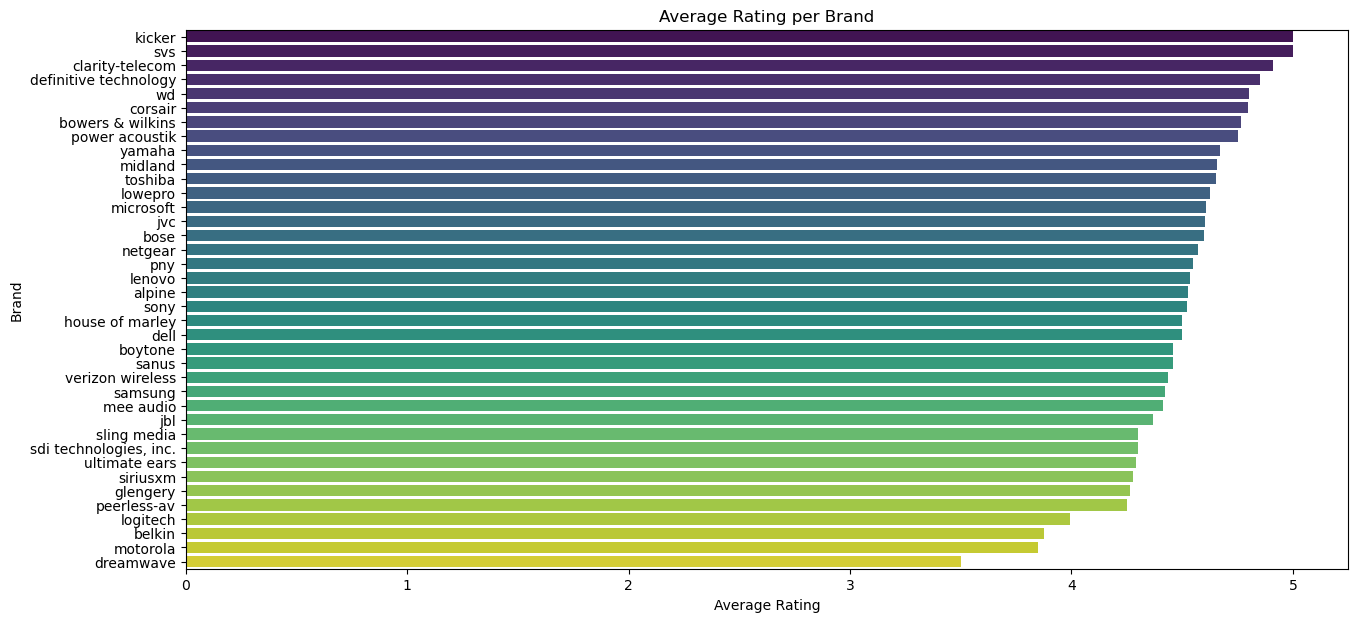

In [24]:
# Calculate the average rating per brand
average_rating_per_brand = data_cleaned.groupby('brand')['reviews.rating'].mean().reset_index()
average_rating_per_brand = average_rating_per_brand.sort_values(by='reviews.rating', ascending=False)

# Plot the average rating per brand
plt.figure(figsize=(15, 7))
sns.barplot(x='reviews.rating', y='brand', data=average_rating_per_brand, palette='viridis')
plt.title('Average Rating per Brand')
plt.xlabel('Average Rating')
plt.ylabel('Brand')
plt.show()

Distribution of Sentiments


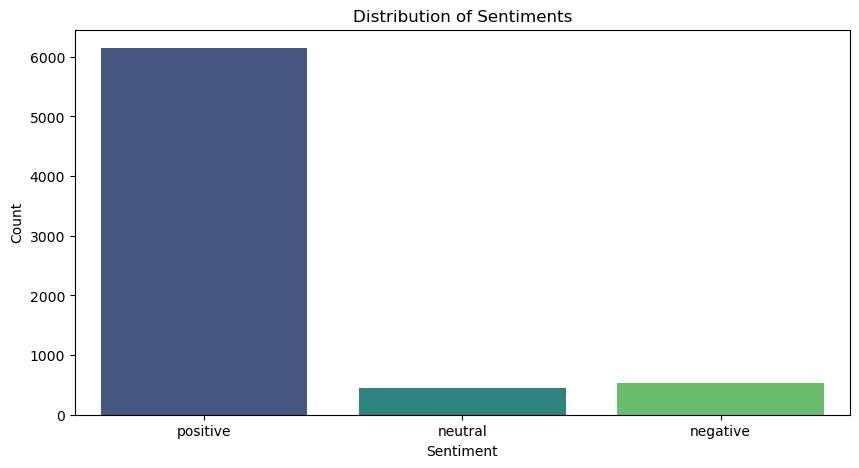

In [25]:
# Plot the distribution of sentiments
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', data=data_cleaned, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Review Length vs. Sentiment


In [26]:
data_cleaned.columns

Index(['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'imageURLs', 'keys', 'manufacturerNumber', 'name', 'primaryCategories',
       'reviews.date', 'reviews.dateSeen', 'reviews.doRecommend',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'upc', 'weight', 'review_length', 'average_rating_x', 'sentiment',
       'word_count', 'num_reviews', 'num_reviews.1', 'processed_reviews',
       'average_rating_y', 'average_rating'],
      dtype='object')

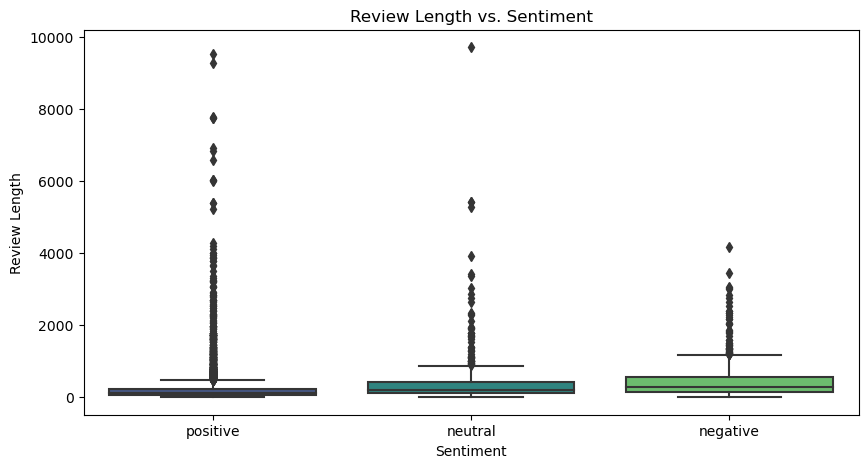

In [27]:
# Plot the distribution of review length by sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='review_length', data=data_cleaned, palette='viridis')
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

The boxplot shows the distribution of review lengths across different sentiments:

- Positive reviews tend to have a slightly higher median review length.

- Negative reviews have a wider range of review lengths, suggesting that users may provide more detailed feedback when they are dissatisfied.

Average Rating vs. Sentiment


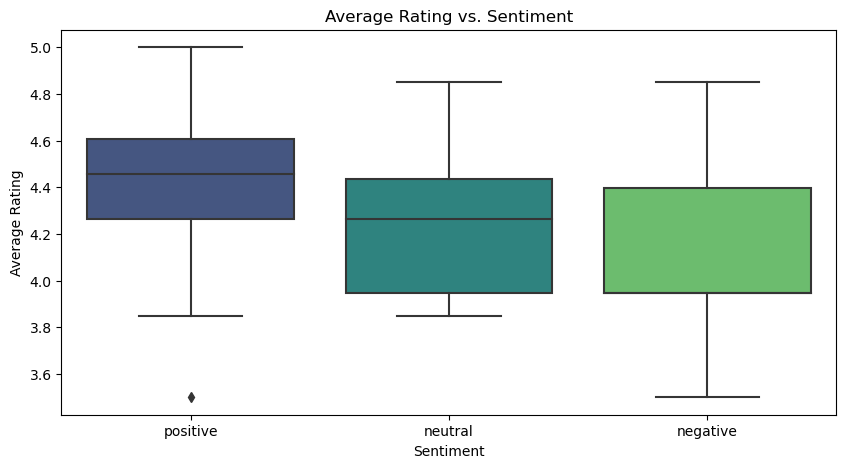

In [28]:
# Plot the distribution of average rating by sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='average_rating', data=data_cleaned, palette='viridis')
plt.title('Average Rating vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Rating')
plt.show()

Reviews Per Product

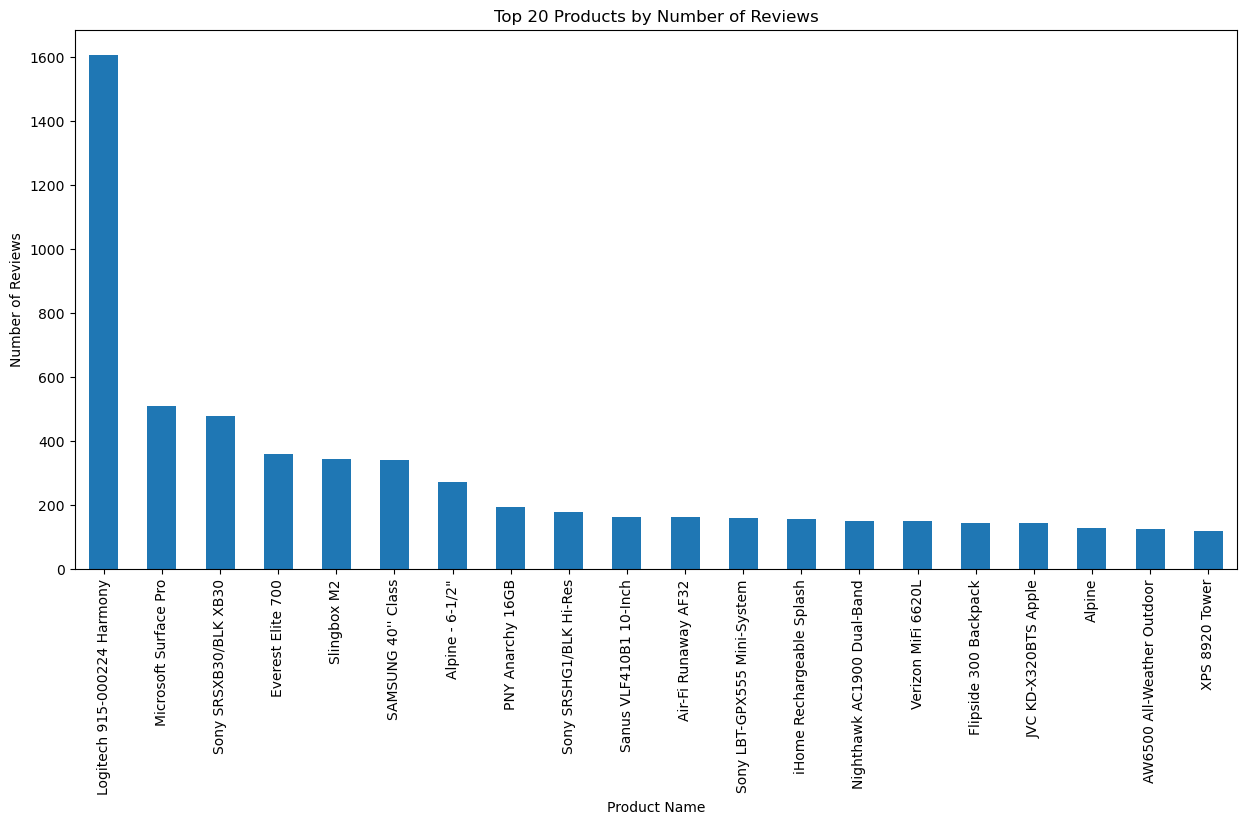

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
path = 'C:/Users/brand/Downloads/MSAAI-540-Final/Dataset/DatafinitiElectronicsProductData.csv'
data = pd.read_csv(path)

# Function to shorten product names
def shorten_name(name):
    words = name.split()
    short_name = ' '.join(words[:3])
    return short_name

# Apply the function to create a new 'short_name' column
data['short_name'] = data['name'].apply(shorten_name)

# Plot the number of reviews per product with shortened names
plt.figure(figsize=(15, 7))
data['short_name'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Products by Number of Reviews')
plt.xlabel('Product Name')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()

Average Rating Per Product

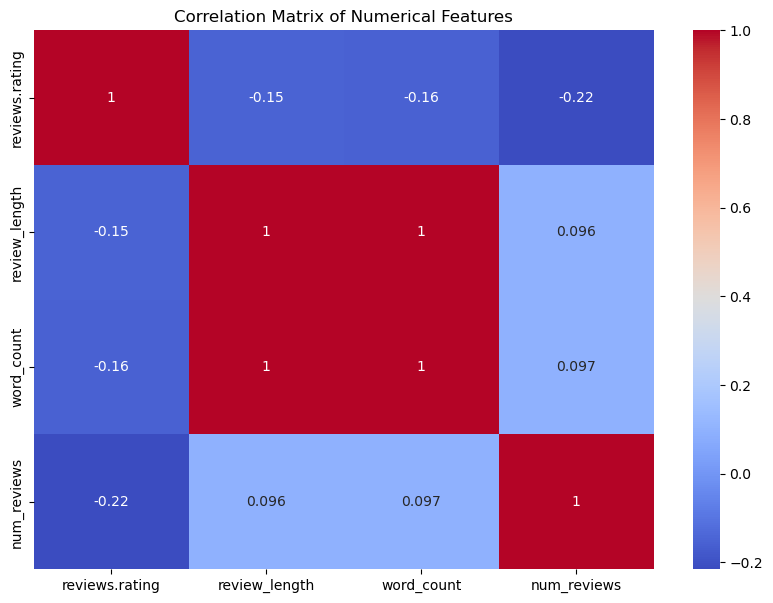

In [30]:
# Calculate correlation matrix
correlation_matrix = data_cleaned[['reviews.rating', 'review_length', 'word_count', 'num_reviews']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [31]:
data_cleaned.to_csv('cleaned_data_with_features.csv', index=False)


In [32]:
data_cleaned = pd.read_csv('cleaned_data_with_features.csv')

# Display the first few rows of the data
data_cleaned['reviews.rating']

0       5.0
1       4.0
2       4.0
3       5.0
4       5.0
       ... 
7121    4.0
7122    4.0
7123    4.0
7124    5.0
7125    4.0
Name: reviews.rating, Length: 7126, dtype: float64

In [33]:
# Ensure we have necessary columns: 'name', 'reviews.username', 'reviews.rating'
data_cleaned = data_cleaned.dropna(subset=['name', 'reviews.username', 'reviews.rating'])

# Rename columns for clarity
data_cleaned.rename(columns={'name': 'product', 'reviews.username': 'user', 'reviews.rating': 'rating'}, inplace=True)

# Display the first few rows to verify
data_cleaned[['product', 'user', 'rating']].head()


,product,user,rating
0,Microsoft Surface Pro 4 Type Cover with Finger...,JNH1,5.0
1,Microsoft Surface Pro 4 Type Cover with Finger...,Appa,4.0
2,Microsoft Surface Pro 4 Type Cover with Finger...,Kman,4.0
3,Microsoft Surface Pro 4 Type Cover with Finger...,UpstateNY,5.0
4,Microsoft Surface Pro 4 Type Cover with Finger...,Glickster,5.0


In [34]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate

# Prepare data 
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data_cleaned[['user', 'product', 'rating']], reader)

# Split data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd = SVD()

# Train the model
svd.fit(trainset)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9690  1.0099  1.0359  1.0183  1.0063  1.0079  0.0219  
MAE (testset)     0.7179  0.7338  0.7645  0.7451  0.7292  0.7381  0.0158  
Fit time          0.06    0.06    0.06    0.07    0.06    0.06    0.00    
Test time         0.01    0.00    0.02    0.00    0.00    0.01    0.01    


{'test_rmse': array([0.96903299, 1.00987047, 1.0358553 , 1.01828174, 1.00628789]),
 'test_mae': array([0.71792503, 0.73380205, 0.76447471, 0.74507145, 0.72922776]),
 'fit_time': (0.056052207946777344,
  0.06459808349609375,
  0.06345701217651367,
  0.06924629211425781,
  0.06281185150146484),
 'test_time': (0.009136199951171875,
  0.002430438995361328,
  0.015682697296142578,
  0.0,
  0.0)}

In [35]:
# Function to get top N recommendations for a given user
def get_recommendations(user_id, model, n=10):
    # Get all unique products
    all_products = data_cleaned['product'].unique()
    
    # Predict ratings for all products
    predictions = [model.predict(user_id, product) for product in all_products]
    
    # Sort predictions by estimated rating
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    
    # Get top N recommendations
    top_n_recommendations = recommendations[:n]
    
    # Return product IDs and estimated ratings
    return [(pred.iid, pred.est) for pred in top_n_recommendations]


In [36]:
user_id = 'TMAN32'  # Replace with an actual user ID from your data
top_recommendations = get_recommendations(user_id, svd, n=10)

# Display the recommendations
for product_id, estimated_rating in top_recommendations:
    print(f"Product: {product_id}, Estimated Rating: {estimated_rating}")

Product: Logitech G403 Wireless Gaming Mouse with High Performance Gaming Sensor, Estimated Rating: 4.893929093112149
Product: NS-IW480CWH In-Ceiling 8 Natural Sound Three-Way Speaker System (Pair), Estimated Rating: 4.846383420179163
Product: JBL - 6" x 8" 2-Way Coaxial Car Speakers with Polypropylene Cones (Pair) - Black, Estimated Rating: 4.844200733035682
Product: Sony Mini Digital Video Cassettes - DVC - 1 Hour, Estimated Rating: 4.831543594085398
Product: Logitech 915-000224  Harmony Ultimate One 15-Device Universal Infrared Remote with Customizable Touch Screen Control - Black, Estimated Rating: 4.830004037285364
Product: Corsair CMSA8GX3M2A1066C7 Apple 8 GB Dual Channel Kit DDR3 1066 (PC3 8500) 204-Pin DDR3 Laptop SO-DIMM Memory 1.5V, Estimated Rating: 4.801154093410798
Product: Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond, Estimated Rating: 4.791859823255737
Product: 2TB Red 5400 rpm SATA III 3.5 Internal NAS HDD, Estimated Rating: 4.783816246504867
Product: Mid

In [37]:


# Load the cleaned dataset
data_cleaned = pd.read_csv('cleaned_data_with_features.csv')

# Ensure there are no NaN values in the 'processed_reviews' column
data_cleaned['processed_reviews'] = data_cleaned['processed_reviews'].fillna('')

# TF-IDF Vectorization of review text
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(data_cleaned['processed_reviews'])

# Dimensionality reduction using Truncated SVD
svd = TruncatedSVD(n_components=100)
review_embeddings = svd.fit_transform(tfidf_matrix)

# Add review embeddings to the dataset
embedding_df = pd.DataFrame(review_embeddings, columns=[f'embedding_{i}' for i in range(100)])
data_cleaned = pd.concat([data_cleaned, embedding_df], axis=1)

data_cleaned.head()



,id,asins,brand,categories,dateAdded,dateUpdated,imageURLs,keys,manufacturerNumber,name,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,AVpf3txeLJeJML43FN82,B0168YIWSI,microsoft,"electronics,computers,computer accessories,key...",2015-11-13 12:28:09+00:00,2018-01-29 02:15:13+00:00,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,-0.013322,-0.004129,-0.034764,0.018824,0.008413,-0.010009,-0.033970,0.027169,-0.003708,0.004014
1,AVpf3txeLJeJML43FN82,B0168YIWSI,microsoft,"electronics,computers,computer accessories,key...",2015-11-13 12:28:09+00:00,2018-01-29 02:15:13+00:00,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,0.012649,0.079395,-0.034760,0.075262,-0.134612,-0.158418,0.028789,-0.095297,0.044833,-0.157120
2,AVpf3txeLJeJML43FN82,B0168YIWSI,microsoft,"electronics,computers,computer accessories,key...",2015-11-13 12:28:09+00:00,2018-01-29 02:15:13+00:00,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,-0.016323,0.013515,-0.045209,-0.103215,0.029520,0.097513,-0.047843,-0.063411,0.080196,-0.085236
3,AVpf3txeLJeJML43FN82,B0168YIWSI,microsoft,"electronics,computers,computer accessories,key...",2015-11-13 12:28:09+00:00,2018-01-29 02:15:13+00:00,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,-0.028685,0.002036,0.004719,0.017934,-0.041855,0.024941,-0.011860,-0.032832,0.000846,0.038192
4,AVpf3txeLJeJML43FN82,B0168YIWSI,microsoft,"electronics,computers,computer accessories,key...",2015-11-13 12:28:09+00:00,2018-01-29 02:15:13+00:00,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,...,-0.008359,-0.038857,0.036878,0.054030,0.009245,-0.020491,-0.001647,-0.128496,-0.069725,0.004371


In [38]:



# Prepare the data for Surprise
reader = Reader(rating_scale=(0, 5))
data_cleaned.rename(columns={'name': 'product', 'reviews.username': 'user', 'reviews.rating': 'rating'}, inplace=True)

data = Dataset.load_from_df(data_cleaned[['user', 'product', 'rating']], reader)

# Use SVD for collaborative filtering
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0619  0.9758  1.0365  0.9690  0.9891  1.0065  0.0364  
MAE (testset)     0.7755  0.7220  0.7494  0.7160  0.7237  0.7373  0.0223  
Fit time          0.06    0.06    0.05    0.05    0.06    0.06    0.01    
Test time         0.00    0.00    0.00    0.02    0.00    0.00    0.01    


{'test_rmse': array([1.06185678, 0.97577493, 1.03649588, 0.9690478 , 0.98913039]),
 'test_mae': array([0.77551052, 0.72202287, 0.74935669, 0.71595759, 0.72370552]),
 'fit_time': (0.06490612030029297,
  0.060098886489868164,
  0.05262351036071777,
  0.047061920166015625,
  0.06388449668884277),
 'test_time': (0.0, 0.0, 0.0, 0.02074575424194336, 0.002589702606201172)}

In [39]:
item_similarity = cosine_similarity(review_embeddings)

In [40]:
def get_similar_items(product_id, top_n=10):
    if product_id not in data_cleaned['product'].values:
        raise ValueError(f"Product ID {product_id} not found in the dataset.")
    
    product_idx = data_cleaned[data_cleaned['product'] == product_id].index[0]
    similar_indices = item_similarity[product_idx].argsort()[-top_n-1:-1][::-1]
    similar_items = data_cleaned.iloc[similar_indices]['product'].values
    return similar_items

# Example usage with an actual product ID from your dataset
example_product_id = data_cleaned['product'].iloc[0]  # Using the first product ID as an example
print(get_similar_items(example_product_id))


['Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID']


In [41]:
# Hybrid Model
from sklearn.base import BaseEstimator

class HybridRecommender(BaseEstimator):
    def __init__(self, svd_model=None, item_similarity_matrix=None):
        self.svd_model = svd_model
        self.item_similarity_matrix = item_similarity_matrix

    def fit(self, X, y=None):
        return self

    def predict(self, user_id, item_id):
        try:
            # SVD prediction
            svd_pred = self.svd_model.predict(user_id, item_id).est
            
            # Content-based prediction
            item_idx = data_cleaned[data_cleaned['product'] == item_id].index[0]
            similar_indices = self.item_similarity_matrix[item_idx].argsort()[-11:-1][::-1]
            similar_items = data_cleaned.iloc[similar_indices]['product'].values
            similar_ratings = [self.svd_model.predict(user_id, sim_item).est for sim_item in similar_items]
            content_pred = np.mean(similar_ratings)
            
            # Combine predictions
            return (svd_pred + content_pred) / 2
        except:
            return svd_pred

    def get_params(self, deep=True):
        return {"svd_model": self.svd_model, "item_similarity_matrix": self.item_similarity_matrix}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


# Create the hybrid recommender
hybrid_model = HybridRecommender(svd, item_similarity)

In [44]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Load and preprocess your data
# Assuming data_cleaned is your preprocessed DataFrame
# data_cleaned = pd.read_csv('your_data.csv')

# Create TF-IDF matrix for item features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_cleaned['processed_reviews'])

# Apply SVD to reduce dimensions
svd = TruncatedSVD(n_components=50)
item_features_matrix = svd.fit_transform(tfidf_matrix)

# Compute item similarity matrix
item_similarity_matrix = cosine_similarity(item_features_matrix)

# Create SVD model for collaborative filtering
reader = Reader(rating_scale=(0, 5))
surprise_data = Dataset.load_from_df(data_cleaned[['user', 'product', 'rating']], reader)
trainset = surprise_data.build_full_trainset()
svd_model = SVD()
svd_model.fit(trainset)

class HybridRecommender(BaseEstimator):
    def __init__(self, svd_model=None, item_similarity_matrix=None):
        self.svd_model = svd_model
        self.item_similarity_matrix = item_similarity_matrix

    def fit(self, X, y=None):
        return self

    def predict(self, user_id, item_id):
        try:
            # SVD prediction
            svd_pred = self.svd_model.predict(user_id, item_id).est
            
            # Content-based prediction
            item_idx = data_cleaned[data_cleaned['product'] == item_id].index[0]
            similar_indices = self.item_similarity_matrix[item_idx].argsort()[-11:-1][::-1]
            similar_items = data_cleaned.iloc[similar_indices]['product'].values
            similar_ratings = [self.svd_model.predict(user_id, sim_item).est for sim_item in similar_items]
            content_pred = np.mean(similar_ratings)
            
            # Combine predictions
            return (svd_pred + content_pred) / 2
        except:
            return svd_pred

    def get_params(self, deep=True):
        return {"svd_model": self.svd_model, "item_similarity_matrix": self.item_similarity_matrix}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Define the parameter grid and custom scorer
def custom_scorer(estimator, X, y):
    y_pred = [estimator.predict(row['user'], row['product']) for _, row in X.iterrows()]
    return -mean_absolute_error(y, y_pred)

param_grid = {
    'svd_model': [svd_model],
    'item_similarity_matrix': [item_similarity_matrix]
}

hybrid_model = HybridRecommender()

grid_search = GridSearchCV(estimator=hybrid_model, param_grid=param_grid, scoring=make_scorer(custom_scorer), cv=5)
grid_search.fit(data_cleaned[['user', 'product']], data_cleaned['rating'])

print(grid_search.best_params_)

# Now you can use the best estimator
best_model = grid_search.best_estimator_

# Example usage
user_id_example = 'VBSSDV'
product_id_example = 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
predicted_rating = best_model.predict(user_id_example, product_id_example)
print(f"Predicted rating for user {user_id_example} on product {product_id_example}: {predicted_rating}")


c:\Users\brand\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\brand\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\brand\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\brand\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\brand\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
TypeError: HybridRecommender.predict() missing 1 required positional argument: 'item_id'

  warnings.warn(


{'item_similarity_matrix': array([[ 1.        ,  0.37897622,  0.38772251, ...,  0.17229595,
        -0.00815694,  0.06553967],
       [ 0.37897622,  1.        ,  0.28658375, ...,  0.08286315,
         0.23825216,  0.19472908],
       [ 0.38772251,  0.28658375,  1.        , ..., -0.03853733,
         0.16193818,  0.07929606],
       ...,
       [ 0.17229595,  0.08286315, -0.03853733, ...,  1.        ,
         0.38548121,  0.147159  ],
       [-0.00815694,  0.23825216,  0.16193818, ...,  0.38548121,
         1.        ,  0.17645651],
       [ 0.06553967,  0.19472908,  0.07929606, ...,  0.147159  ,
         0.17645651,  1.        ]]), 'svd_model': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000209D00A3820>}
Predicted rating for user VBSSDV on product Microsoft Surface Pro 4 Type Cover with Fingerprint ID: 4.772801706115471


c:\Users\brand\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


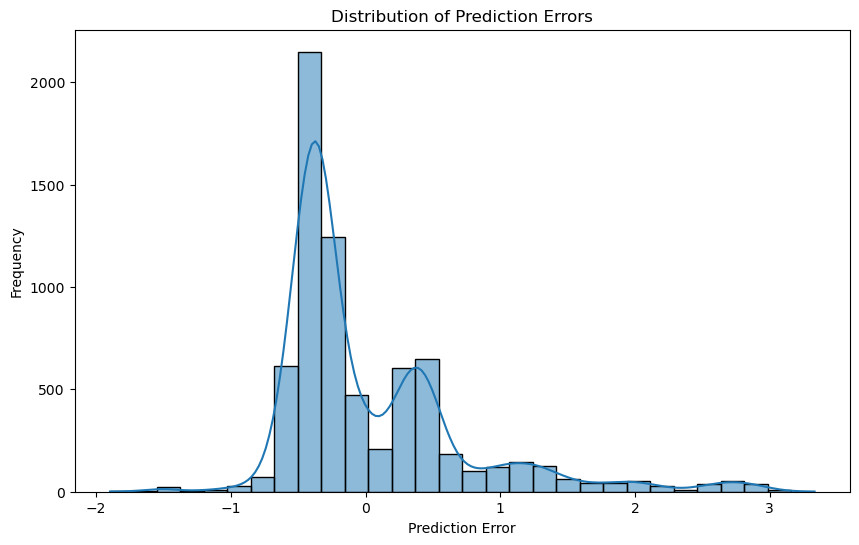

In [45]:
# Get predictions and true values
y_true = data_cleaned['rating']
y_pred = [best_model.predict(row['user'], row['product']) for _, row in data_cleaned.iterrows()]

# Calculate errors
errors = np.array(y_pred) - np.array(y_true)

# Plot distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


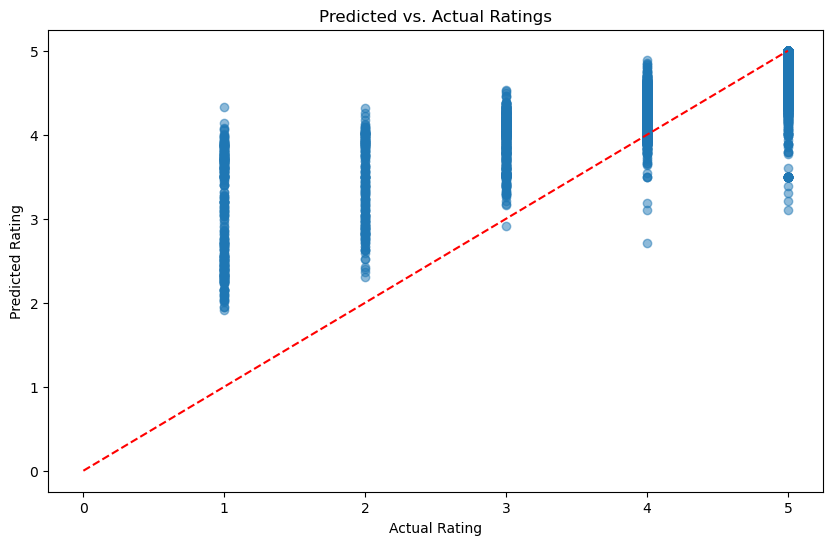

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 5], [0, 5], '--', color='red')
plt.title('Predicted vs. Actual Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()


In [47]:
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Mean Absolute Error (MAE): 0.5125
Mean Squared Error (MSE): 0.4881
Root Mean Squared Error (RMSE): 0.6986
